## Visualizing Models, Data, and Training with TensorBoard

### 1. Initial Setup

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.CIFAR10('../lab4/data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('../lab4/data',
    download=True,
    train=False,
    transform=transform)


# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

net = torchvision.models.resnet18(weights='IMAGENET1K_V1')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Files already downloaded and verified
Files already downloaded and verified


### 2. TensorBoard Setup

Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.

In [3]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/cifar10_experiment_1')

### 3. Adding a Figure to TensorBoard

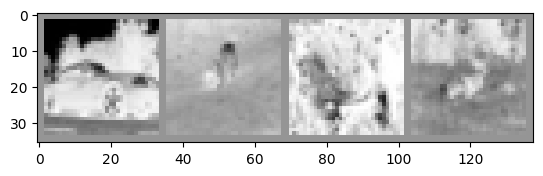

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('cifar10_images', img_grid)

### 4. Launch TensorBoard

Use the following command to launch TensorBoard:

```bash
tensorboard --logdir=runs
```

This will start a local server and open a new tab in your web browser.


### 5. View the structure of the model

In [5]:
writer.add_graph(net, images)
writer.close()

### 6. Adding a "Projector" to TensorBoard

It is useful to visualize the lower dimensional representations of higher dimensional data via the add_embedding method.

In [6]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    perm = perm[:n].tolist()  # Convert to list for indexing
    print(perm)
    data_np = np.array(data)  # Convert data to a NumPy array
    labels_np = np.array(labels)  # Convert labels to a NumPy array
    return data_np[perm], labels_np[perm]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = torch.tensor(images).reshape(-1, 32 * 32 * 3)  # Adjust the view to match image dimensions
label_img = torch.tensor(images).permute(0, 3, 1, 2)  # Ensure the shape is (N, C, H, W) for RGB images
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=label_img)
writer.close()

[29400, 45677, 23055, 23687, 9297, 468, 14590, 46567, 32124, 6319, 10710, 48484, 10420, 18250, 35979, 10680, 45528, 14566, 9655, 22291, 36012, 38681, 7025, 1275, 34588, 23039, 26000, 33177, 29955, 27759, 24338, 28147, 47842, 24132, 29256, 10582, 4669, 47302, 24271, 43456, 4058, 19797, 37152, 29245, 44655, 15669, 26318, 26395, 22434, 20178, 39729, 2357, 9247, 20969, 9359, 41528, 31942, 14473, 25859, 48024, 36925, 39828, 26079, 13928, 29766, 44905, 41341, 16162, 8401, 18913, 43858, 36371, 26368, 8205, 23520, 37030, 24578, 18485, 12549, 9312, 46858, 15933, 20128, 43911, 12273, 23370, 49416, 29727, 3735, 20269, 4403, 7434, 41671, 24704, 39611, 21261, 45838, 18741, 18777, 21065]


### 7. Tracking Model Training with TensorBoard

In [10]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu(), one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

# training loop
running_loss = 0.0
net = net.cuda()
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].cuda(), data[1].cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training
